<a href="https://colab.research.google.com/github/ManviRankawat/CompVis_Autostereogram_FinalProj/blob/main/autostereogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage, skimage.io
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
def blank_image(shape=(600, 800, 4), rgba=(255, 255, 255, 0)):
    """Returns a blank image, of size defined by shape and background color RGBA."""
    return np.ones(shape, dtype=float) * np.array(rgba) / 255.

In [4]:
img = blank_image()

In [5]:
def display(img, colorbar=False):
    "Displays an image."
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = skimage.io.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


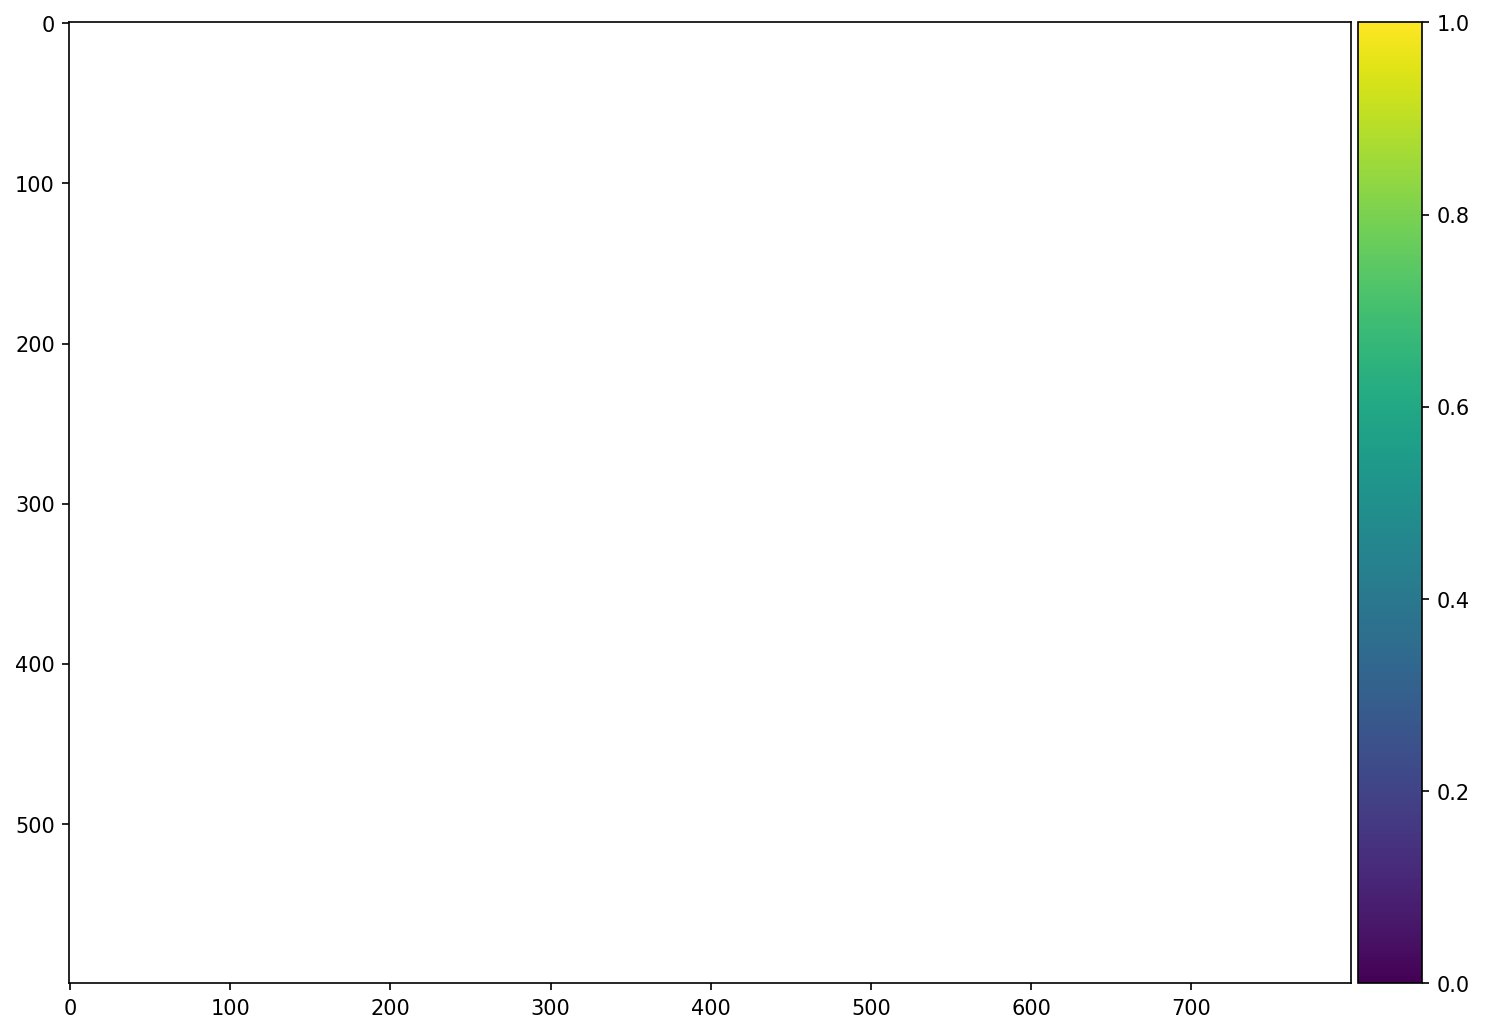

In [6]:
display(img)

In [7]:
rubrix = skimage.io.imread('/content/sample_data/rubiks.jpg')

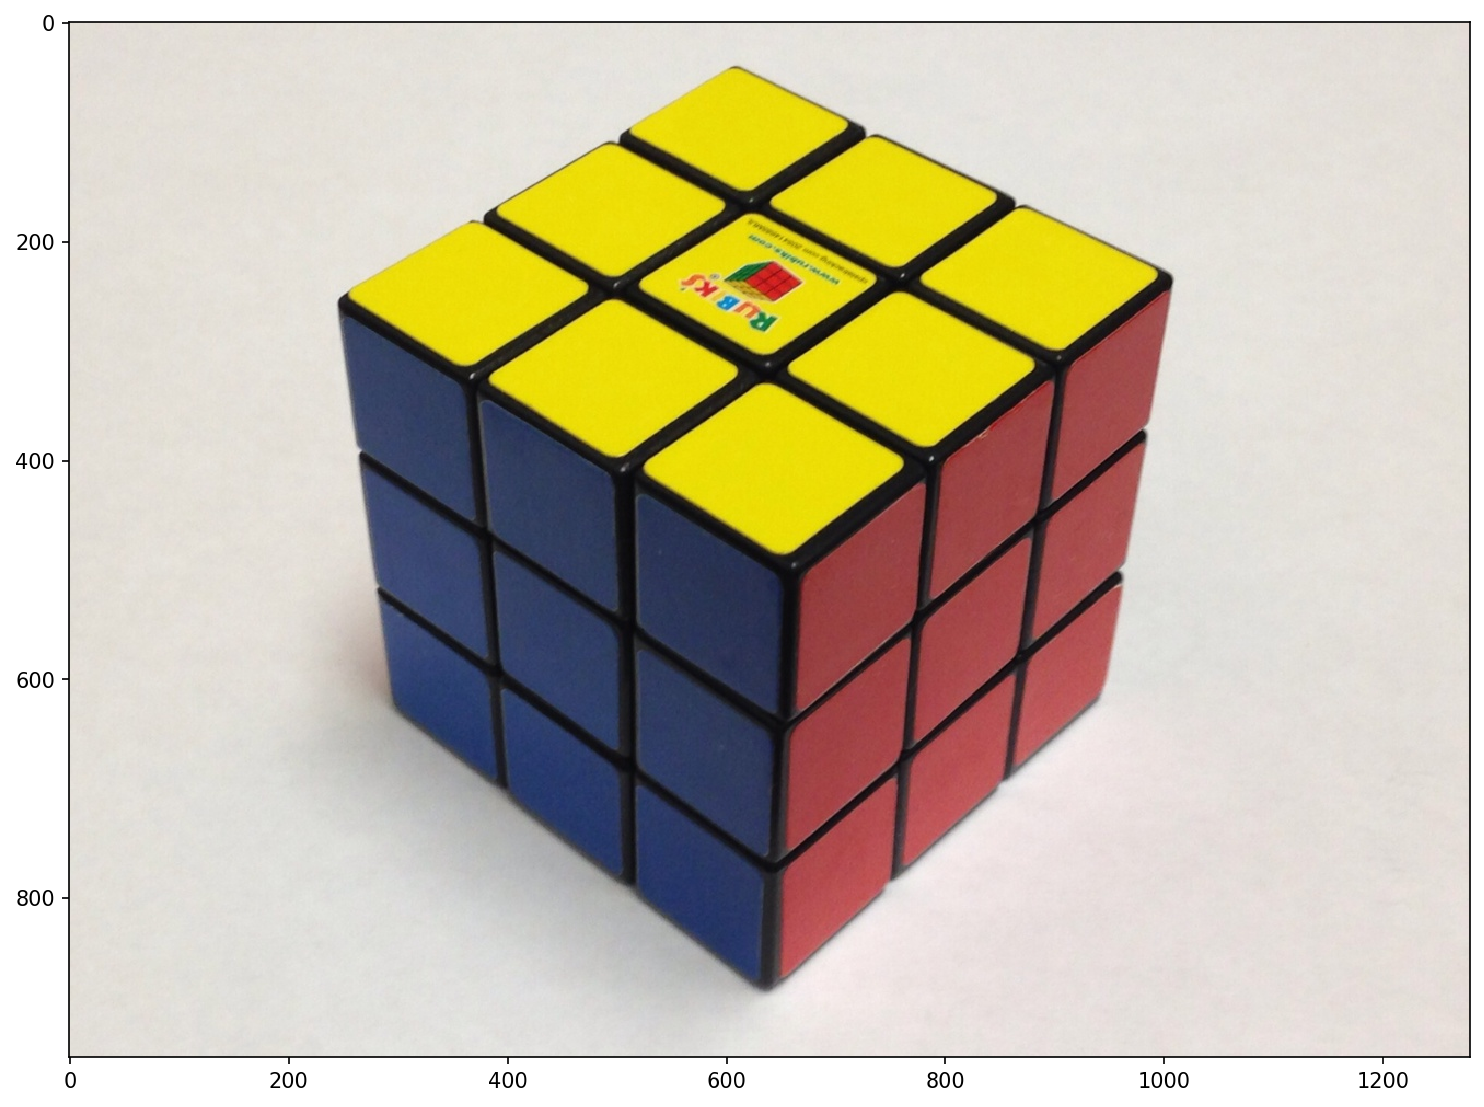

In [8]:
display(rubrix)

In [9]:
from skimage import img_as_float

In [10]:
from skimage.color import gray2rgb

def insert_pattern(background_img, pattern, location):
    """Inserts a pattern onto a background at the given location, handling boundaries."""
    img = background_img.copy()
    r0, c0 = location
    r1, c1 = r0 + pattern.shape[0], c0 + pattern.shape[1]

    # Adjust the pattern size if it exceeds background boundaries
    if r1 > background_img.shape[0]:
        pattern = pattern[:background_img.shape[0] - r0, :, :]
        r1 = background_img.shape[0]
    if c1 > background_img.shape[1]:
        pattern = pattern[:, :background_img.shape[1] - c0, :]
        c1 = background_img.shape[1]

    # Check if the pattern has 3 channels (RGB)
    if pattern.shape[-1] == 3:
        # Add an alpha channel to match the background
        alpha_channel = np.ones((pattern.shape[0], pattern.shape[1], 1), dtype=pattern.dtype) * 255
        pattern = np.concatenate([pattern, alpha_channel], axis=-1)

    img[r0:r1, c0:c1, :] = pattern
    return img

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


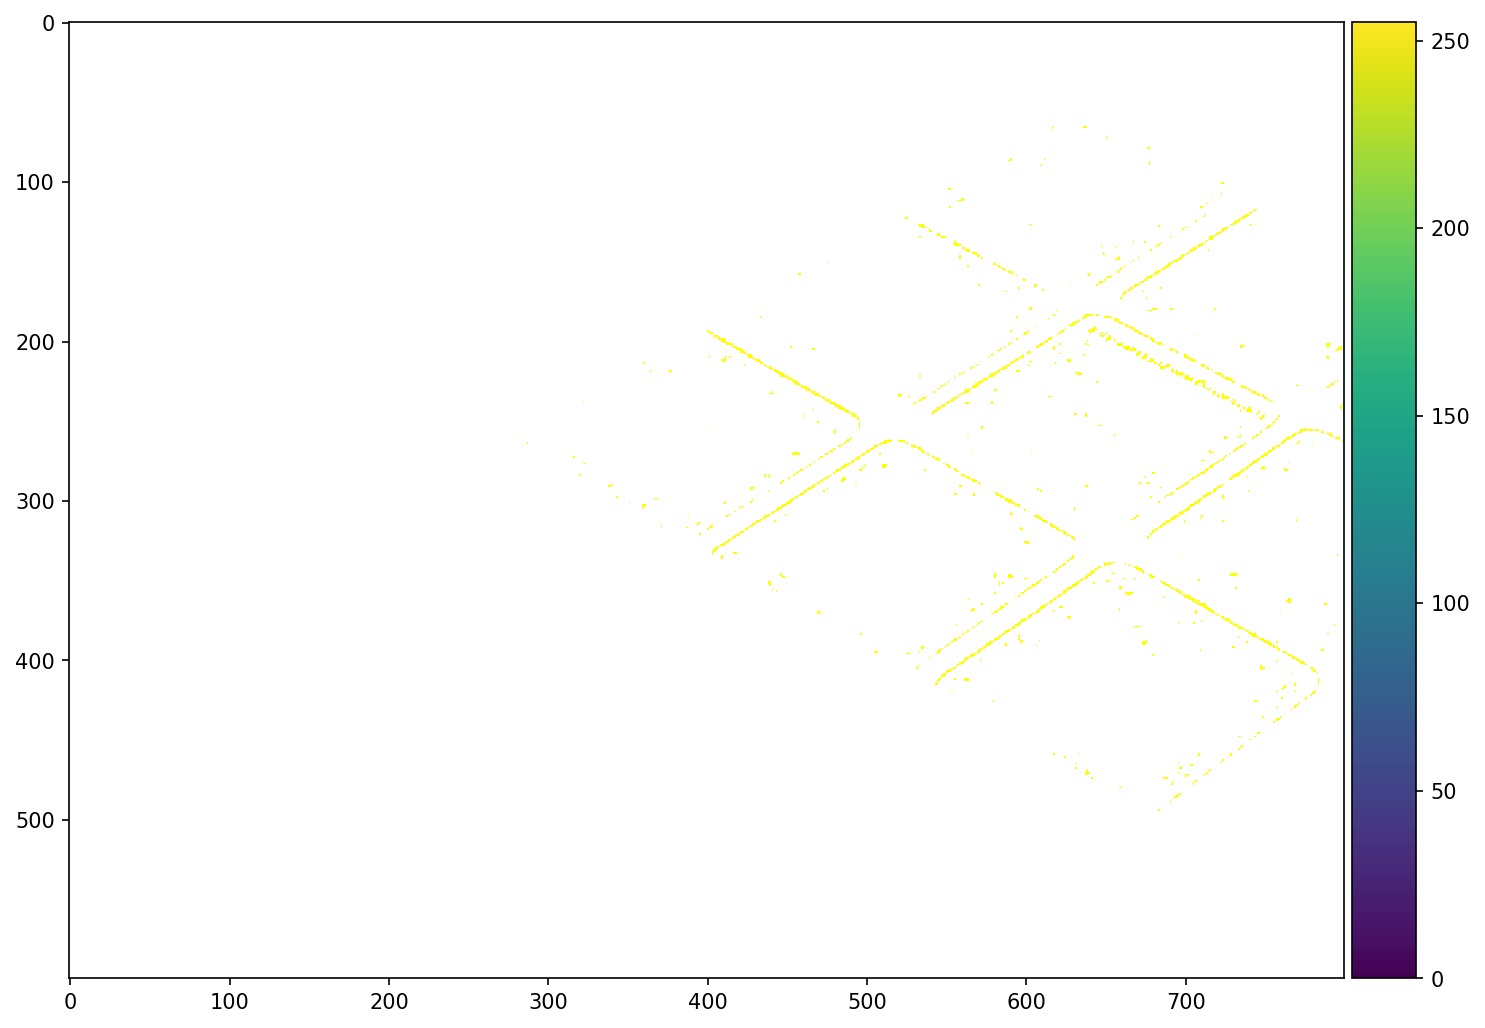

In [12]:
test_img = insert_pattern(img, rubrix, (10, 20))
display(test_img)


In [13]:
def tile_horizontally(background_img, pattern, start_location, repetitions, shift=None, padding=0):
    """
    Tiles a pattern on a background image, repeatedly with a given shift.
    Optionally adds padding between tiles.
    """
    img = background_img.copy()
    r, c = start_location

    # Use pattern width as default shift if not specified
    if shift is None:
        shift = pattern.shape[1] + padding

    for i in range(repetitions):
        c_new = c + i * shift  # Compute new column for the current tile

        # Debugging dimensions
        print(f"Placing tile {i+1}: (row, col)=({r}, {c_new})")

        # Ensure the tile fits within the background
        if c_new + pattern.shape[1] <= background_img.shape[1]:
            img = insert_pattern(img, pattern, location=(r, c_new))
        else:
            print(f"Skipping tile at position {(r, c_new)}: exceeds background width.")
            break  # Stop further tiling as subsequent tiles will also exceed the width.

    # Clip image values for display
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


In [16]:
shift = rubrix.shape[1] + 10  # Coin width + 10px padding
test_img = tile_horizontally(img, rubrix, (10, 20), repetitions=3, shift=shift)

Placing tile 1: (row, col)=(10, 20)
Skipping tile at position (10, 20): exceeds background width.


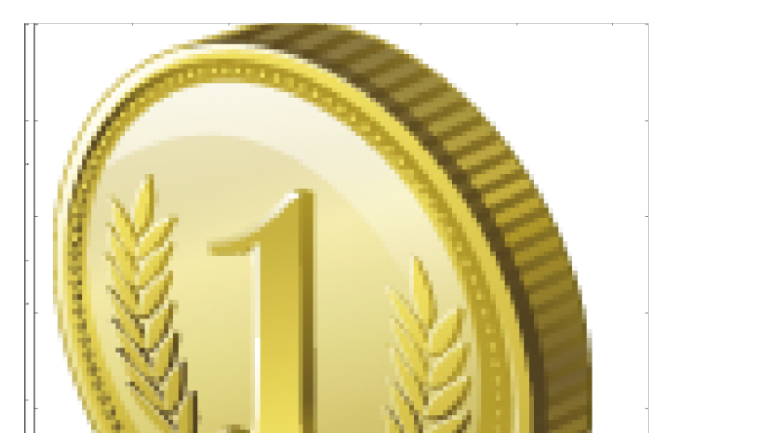

In [ ]:
plt.imshow(test_img / 255.0)  # Normalize if the image has integer values [0, 255]
plt.axis('off')
plt.show()


Placing tile 1: (row, col)=(10, 10)
Placing tile 2: (row, col)=(10, 140)
Skipping tile at position (10, 140): exceeds background width.
Placing tile 1: (row, col)=(160, 10)
Placing tile 2: (row, col)=(160, 160)
Skipping tile at position (160, 160): exceeds background width.
Placing tile 1: (row, col)=(310, 10)
Placing tile 2: (row, col)=(310, 150)
Skipping tile at position (310, 150): exceeds background width.


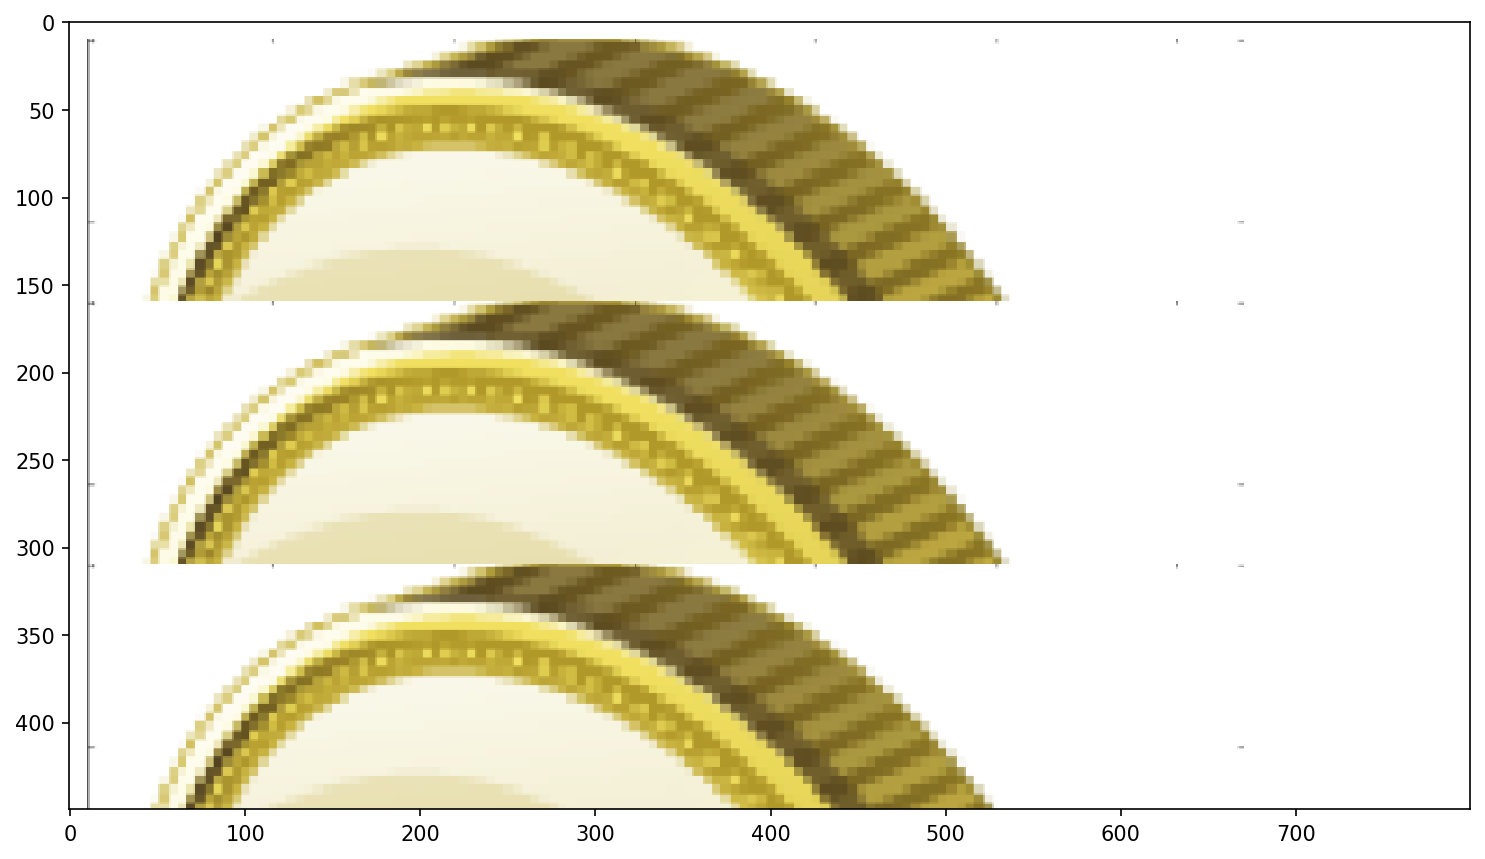

In [ ]:
# Clip image values to valid range for display
img = np.clip(img, 0, 255).astype(np.uint8)  # Ensure values are in [0, 255] range and convert to integers
img = blank_image(shape=(450, 800, 4))
img = tile_horizontally(img, coin, (10, 10), 6, shift=130)
img = tile_horizontally(img, coin, (10 + 150, 10), 5, shift=150)
img = tile_horizontally(img, coin, (10 + 2*150, 10), 5, shift=140)
display(img)

In [ ]:
def make_pattern(shape=(16, 16), levels=64):
    "Creates a pattern from gray values."
    return np.random.randint(0, levels - 1, shape) / levels

In [ ]:
pattern = make_pattern(shape=(128, 64))

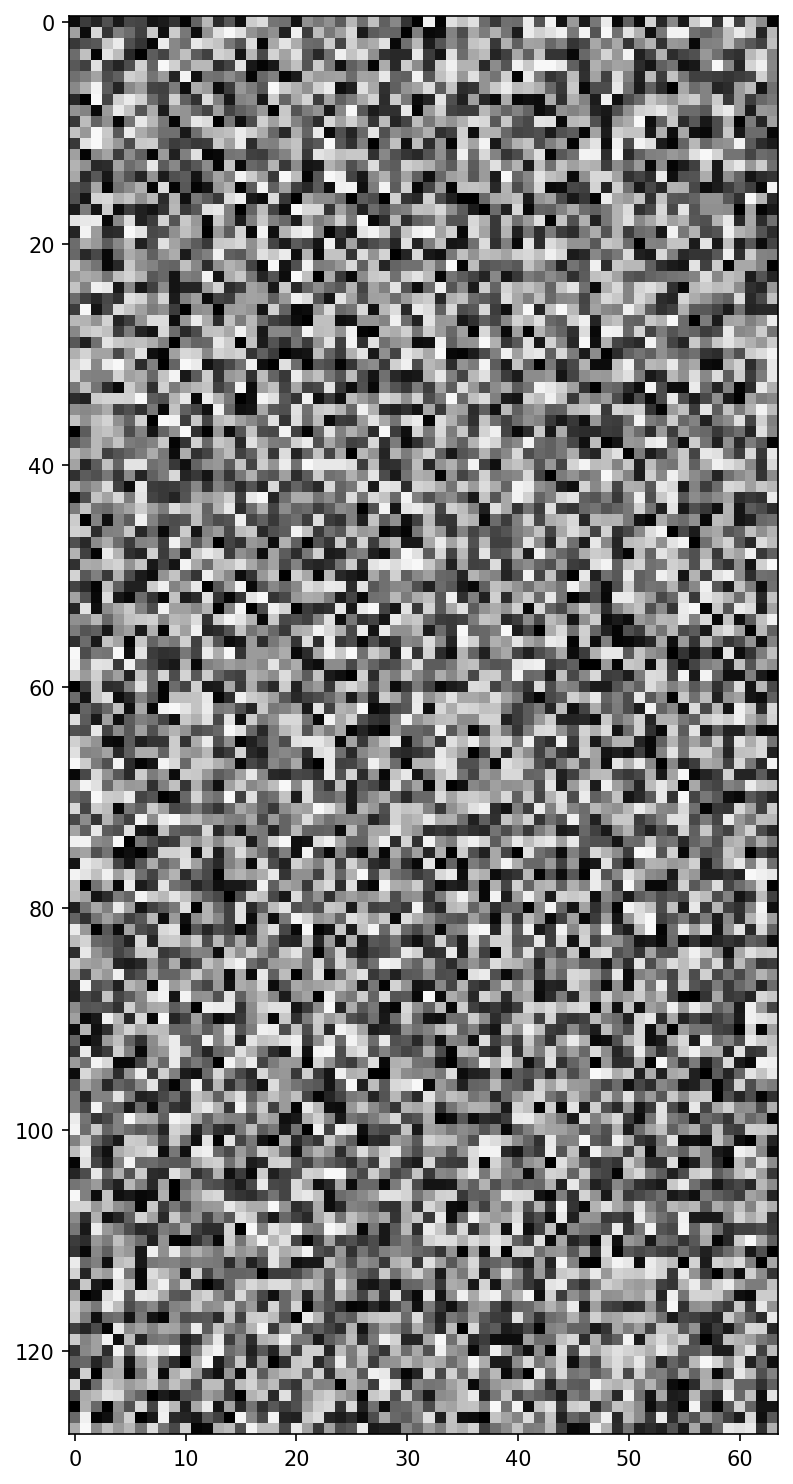

In [ ]:
display(pattern)

In [ ]:
def create_circular_depthmap(shape=(600, 800), center=None, radius=100):
    """Creates a circular depthmap, centered on the image."""
    depthmap = np.zeros(shape, dtype=float)  # Use float instead of np.float
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap

In [ ]:
depthmap = create_circular_depthmap(radius=150)

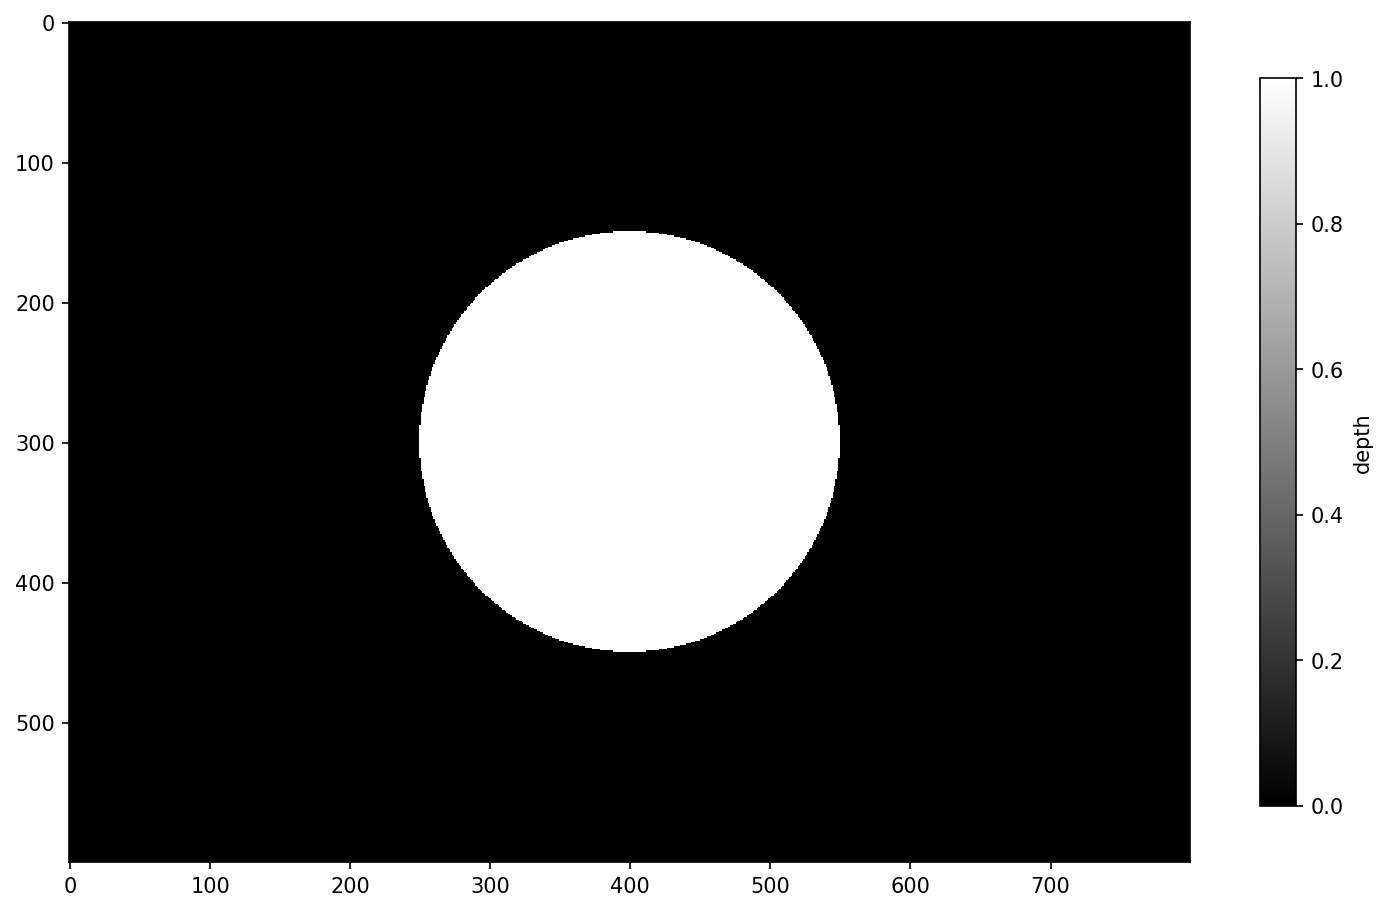

In [ ]:
display(depthmap, colorbar=True)

In [ ]:
def normalize(depthmap):
    "Normalizes values of depthmap to [0, 1] range."
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

In [ ]:
def make_autostereogram(depthmap, pattern, shift_amplitude=0.1, invert=False):
    "Creates an autostereogram from depthmap and pattern."
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
    for r in np.arange(autostereogram.shape[0]):
        for c in np.arange(autostereogram.shape[1]):
            if c < pattern.shape[1]:
                autostereogram[r, c] = pattern[r % pattern.shape[0], c]
            else:
                shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    return autostereogram

In [ ]:
autostereogram = make_autostereogram(depthmap, pattern)

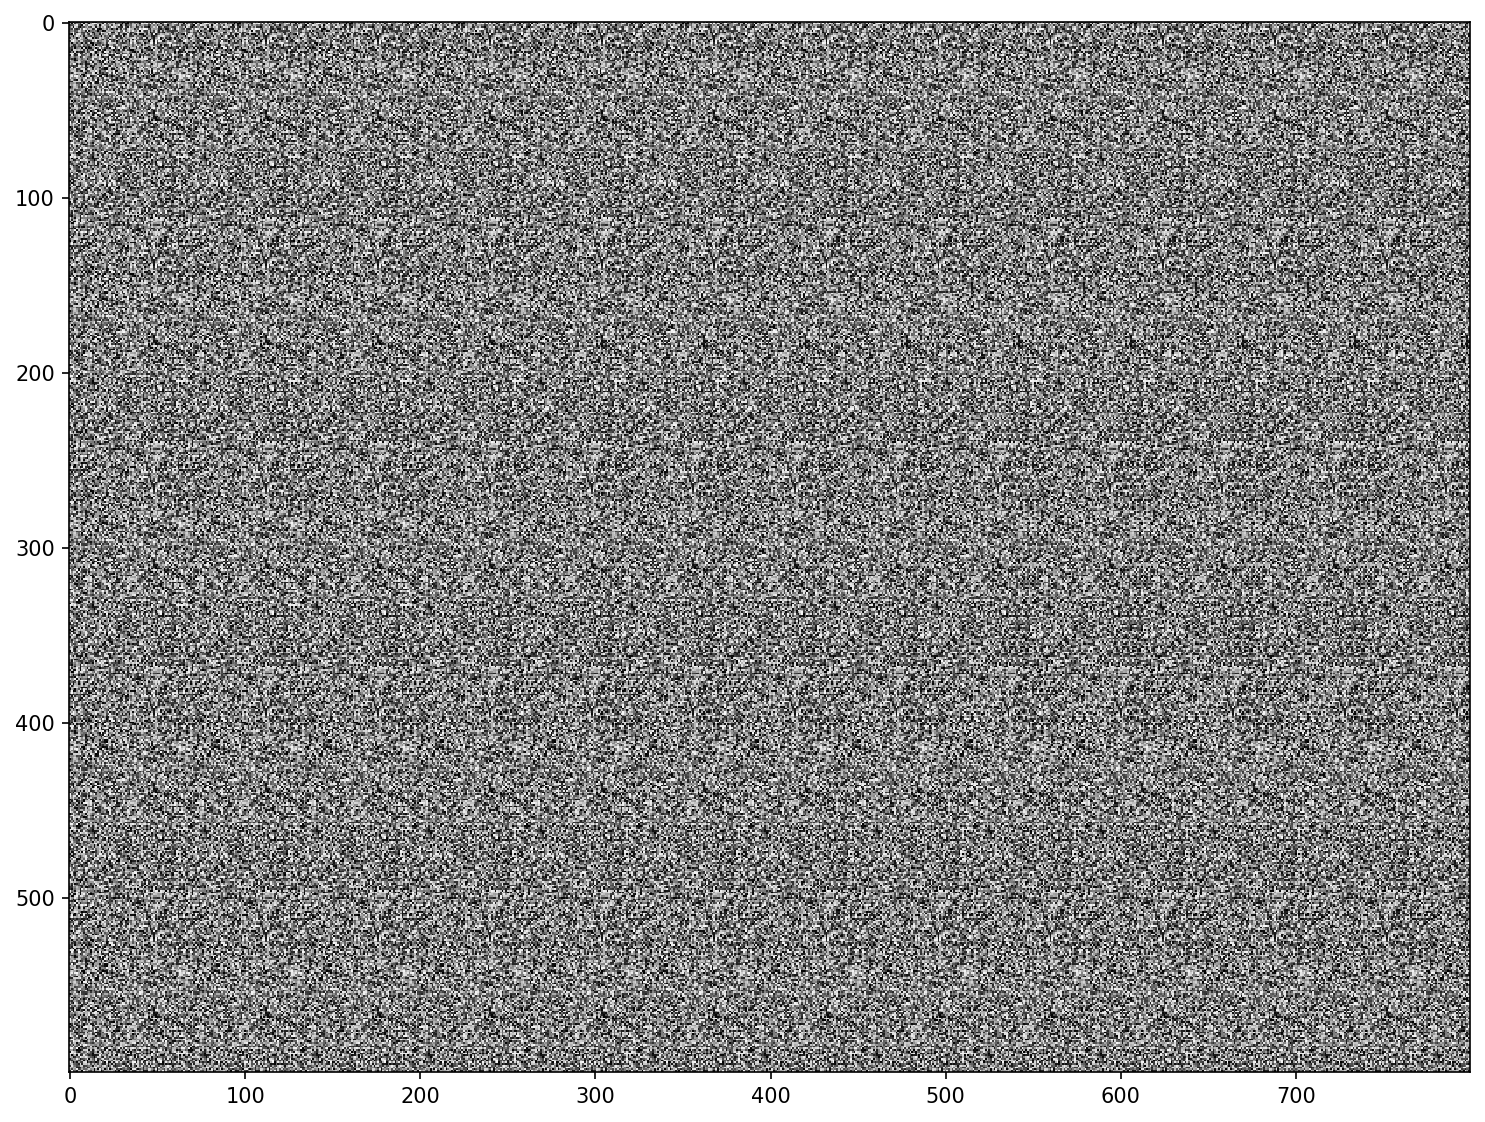

In [ ]:
display(autostereogram)

In [ ]:
autostereogram = make_autostereogram(depthmap, pattern, invert=True)

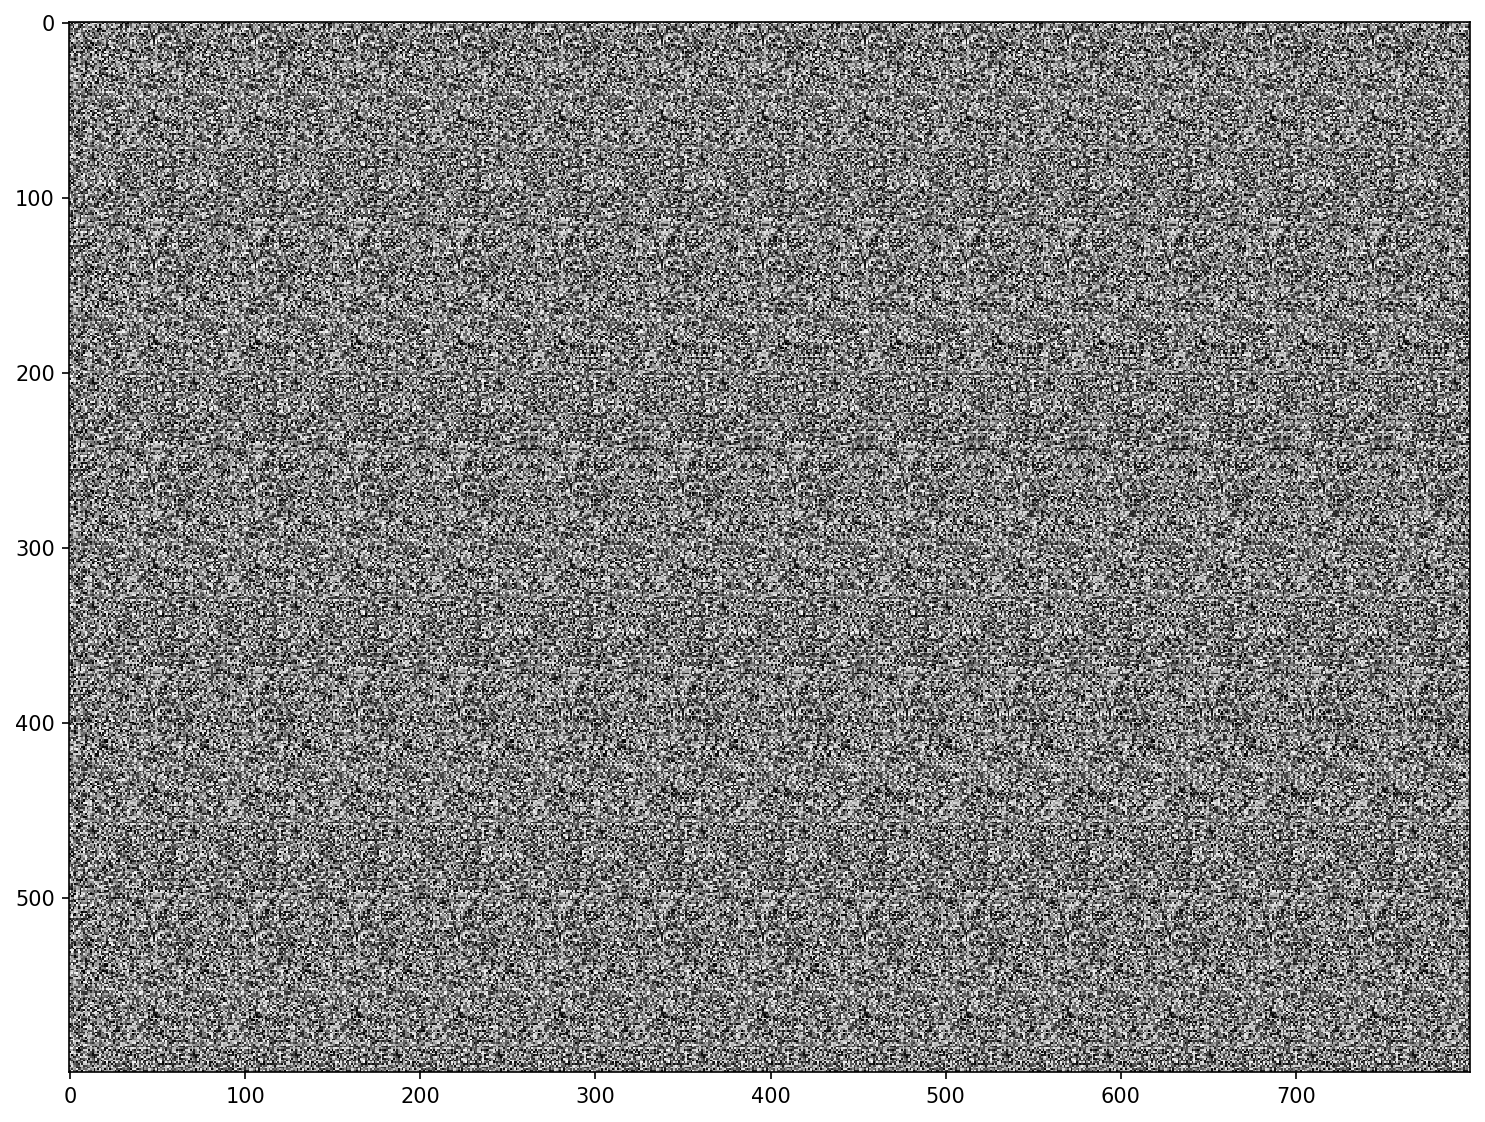

In [ ]:
display(autostereogram)

In [ ]:
depthmap = create_circular_depthmap(center=(200, 300), radius=100) + \
           create_circular_depthmap(center=(450, 500), radius=100) + \
           create_circular_depthmap(center=(200, 550), radius=150)
depthmap = normalize(depthmap)

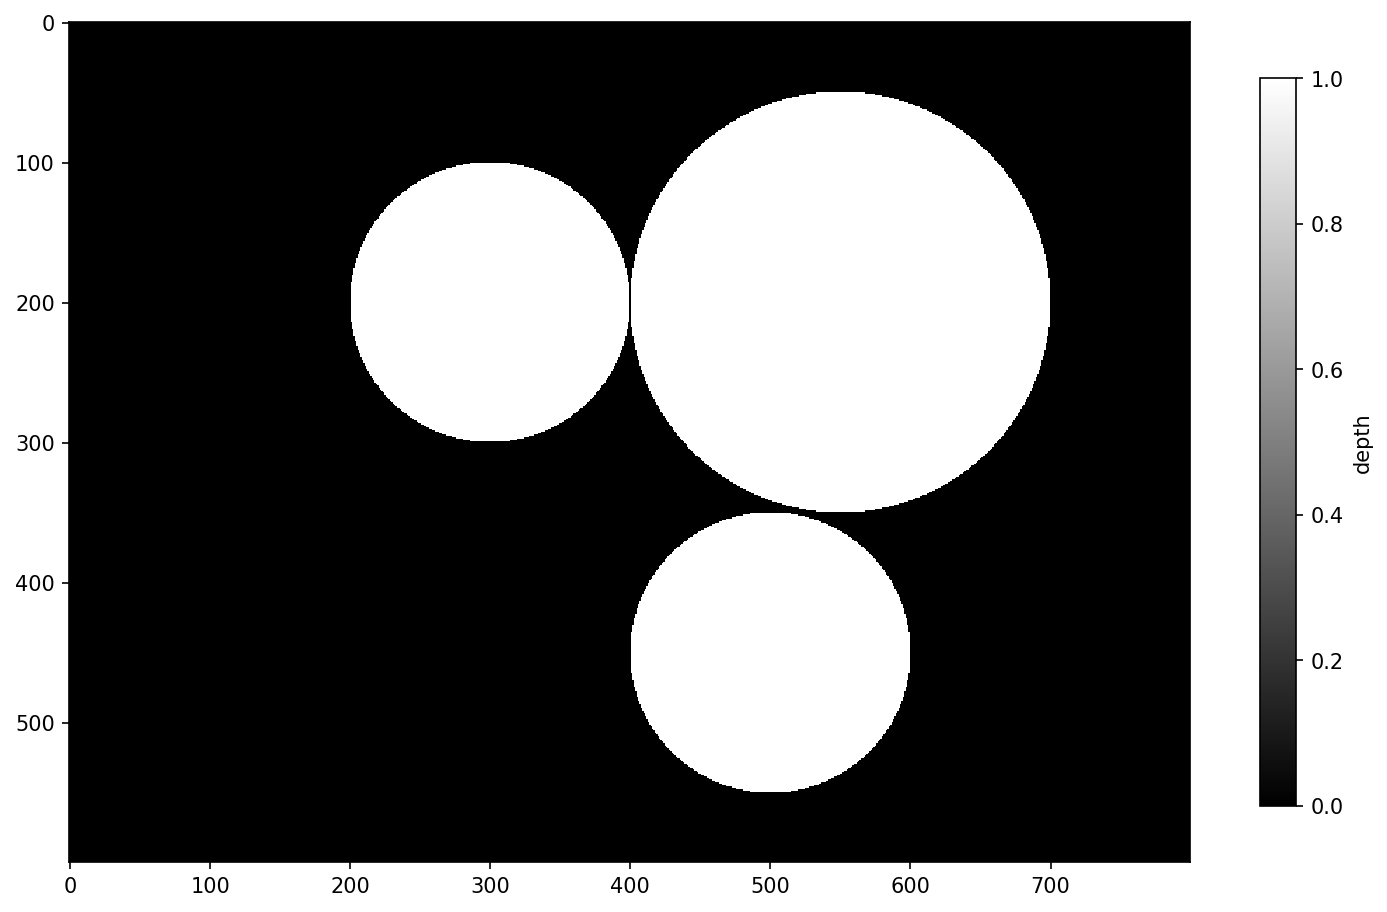

In [ ]:
display(depthmap, colorbar=True)

In [ ]:
autostereogram = make_autostereogram(depthmap, pattern)

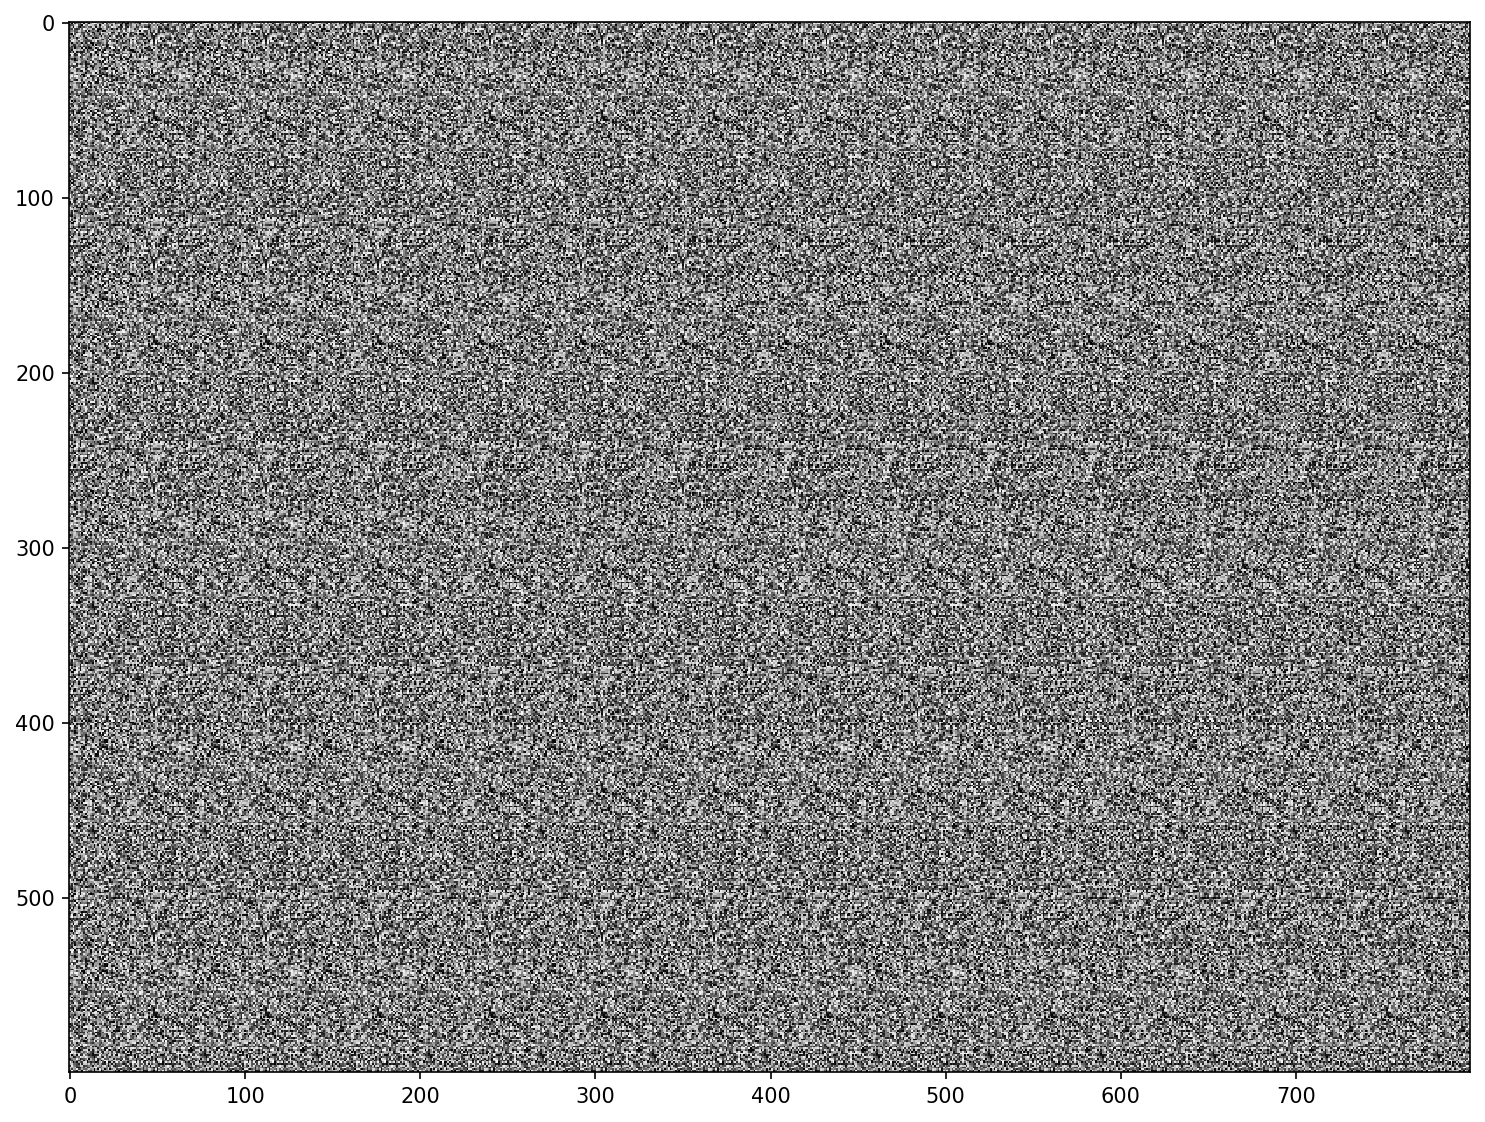

In [ ]:
display(autostereogram)

In [ ]:
!pip install https://github.com/Lasagne/Lasagne/archive/master.zip

     - 232.0 kB 9.7 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-py3-none-any.whl size=122788 sha256=c21c690415e0b30c1cfacefdd75c9820486975b6632f636c7f05c6aaa03301cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-qcaisi_z/wheels/0e/99/a1/7e3cbd28fcb9f931acf8668fdd7732d279952635202adbe26a
Successfully built Lasagne


In [ ]:
# Define the CNN model
class StereoCNN(nn.Module):
    def __init__(self):
        super(StereoCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 96, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(96, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 96, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(96, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training loop
def train_model(X_train, y_train, X_val, y_val, num_epochs=10, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StereoCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Create DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("No data available for training or validation.")
        return

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

# Main execution
if __name__ == '__main__':
    X_train, y_train, X_val, y_val = load_stereo_images()
    if X_train is not None and y_train is not None:
        train_model(X_train, y_train, X_val, y_val)


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'